<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/ppf_bis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Model for Drug Effect Prediction
In this example, we will build a model to predict bispectral index value during the anesthesia using propofol and remifentanil.

## Required libraries

In [2]:
!pip install vitaldb

import vitaldb
import numpy as np
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Case selection

Load data using the VitalDB Open Dataset API endpoints.


In [3]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')
df_cases = pd.read_csv("https://api.vitaldb.net/cases")
df_cases['sex'] = (df_cases['sex'] == 'F').astype(int)  # female: 1, male: 0

Inclusion, exclusion criteria
* More than 2 hours
* General anesthesia
* Age >= 18
* PPF20_VOL, RFTN20_VOL, PPF20_CE, RFTN20_CE, BIS tracks should exist
* Weight > 35 kg

In [4]:
caseids = list(
  set(df_trks[df_trks['tname'] == 'Orchestra/PPF20_VOL']['caseid']) &
  set(df_trks[df_trks['tname'] == 'Orchestra/RFTN20_VOL']['caseid']) &
  set(df_trks[df_trks['tname'] == 'Orchestra/PPF20_CE']['caseid']) &
  set(df_trks[df_trks['tname'] == 'Orchestra/RFTN20_CE']['caseid']) &
  set(df_trks[df_trks['tname'] == 'BIS/BIS']['caseid']) & 
  set(df_cases[df_cases['age'] > 18]['caseid']) & 
  set(df_cases[df_cases['weight'] > 35]['caseid']) &
  set(df_cases[df_cases['caseend'] > 7200]['caseid']) &
  set(df_cases[df_cases['ane_type'] == 'General']['caseid'])
  )
np.random.shuffle(caseids)
len(caseids)

2225

## Preprocessing
* Set a variable to save the dataset
* Read BIS and the infusion rates of propofol and remifentanil
* Skip the cases where the recorded data is short, there was no drug infusion, and the bis value is not appropriate.
* Preprocess missing values and negative numbers

In [5]:
x_ppf_dose = []  # Propofol dose of each record
x_rft_dose = []  # Remifentanil dose of each record
x_aswh = []  # Age, gender, height, weight of each record
c = []  # Caseid of each record
y = []  # Output of each record (bis)
y_old = []  # Predicted value of classical model

LSTM_TIMEPOINTS = 180  # 180 timpoints x 10 sec/timepoints = 1800 sec
LSTM_NODES = 8
FNN_NODES = 16
BATCH_SIZE = 256  # Number of records to process at one time
MAX_CASES = 50  # Maximum number of cases to use in this example

# Column order when loading data
PPF_DOSE = 0
RFT_DOSE = 1
PPF_CE = 2
RFT_CE = 3
BIS = 4

for caseid in caseids:  # for each caseids
    print(f'loading {caseid}', end='...', flush=True)

    # Extract data every 10 seconds
    vals = vitaldb.load_case(caseid, ['Orchestra/PPF20_VOL', 'Orchestra/RFTN20_VOL', 'Orchestra/PPF20_CE', 'Orchestra/RFTN20_CE', 'BIS/BIS'], 10)

    # Replace missing values with the last value measured
    vals = pd.DataFrame(vals).fillna(method='ffill').values
    vals = np.nan_to_num(vals, 0)  # Replace missing values at beginning with 0

    # Excluding cases where drug injection was not performed or cases where bis was not used
    if (np.max(vals, axis=0) <= 1).any():
        print('no drug infusion or bis')
        continue

    # Get the drug infusion start time and delete the previous one
    first_ppf_idx = np.where(vals[:, PPF_DOSE] > 1)[0][0]
    first_rft_idx = np.where(vals[:, RFT_DOSE] > 1)[0][0]
    first_drug_idx = min(first_ppf_idx, first_rft_idx)
    vals = vals[first_drug_idx:, :]

    # Change volume to rate
    vals[1:, PPF_DOSE] -= vals[:-1, PPF_DOSE]
    vals[1:, RFT_DOSE] -= vals[:-1, RFT_DOSE]
    vals[0, PPF_DOSE] = 0
    vals[0, RFT_DOSE] = 0

    # Replace negative values (decrease in volume) with 0
    vals[vals < 0] = 0

    # 1) Excluding cases where the first value of bis is less than or equal to 80
    # 2) Excluding cases where the last value is less than or equal to 70
    valid_bis_idx = np.where(vals[:, BIS] > 0)[0]
    first_bis_idx = valid_bis_idx[0]
    last_bis_idx = valid_bis_idx[-1]
    if vals[first_bis_idx, BIS] < 80:
        print('first bis < 80')
        continue
    if vals[last_bis_idx, BIS] < 70:
        print('last bis < 70')
        continue

    # Set both dose and bis during LSTM_TIMEPOINTS before infusion to 0 
    vals = np.vstack((np.zeros((LSTM_TIMEPOINTS - 1, vals.shape[1])), vals))

    # Get the current case's age, gender, height, and weight
    aswh = df_cases.loc[df_cases['caseid'] == caseid, ['age','sex','weight','height']].values.astype(float).flatten()

    # Append the bis from the beginning to the end into the dataset
    for irow in range(1, vals.shape[0] - LSTM_TIMEPOINTS - 1):
        bis = vals[irow + LSTM_TIMEPOINTS, BIS]
        if bis == 0:
            continue

        # Append input values into dataset
        x_ppf_dose.append(vals[irow:irow + LSTM_TIMEPOINTS, PPF_DOSE])
        x_rft_dose.append(vals[irow:irow + LSTM_TIMEPOINTS, RFT_DOSE])

        x_aswh.append(aswh)
        c.append(caseid)
        y.append(bis / 100)

        ppf_ce = vals[irow + LSTM_TIMEPOINTS, PPF_CE]
        rft_ce = vals[irow + LSTM_TIMEPOINTS, RFT_CE]
        
        ug = (ppf_ce / 4.47 + rft_ce / 19.3)**1.43
        g = 1.43

        y_old.append(0.98 - 0.98 * (ug / (1 + ug)))

    print('done')
    if len(np.unique(c)) >= MAX_CASES:
        break


loading 5467...done
loading 5065...done
loading 5828...first bis < 80
loading 5301...first bis < 80
loading 6089...done
loading 3148...done
loading 3093...first bis < 80
loading 2324...done
loading 6203...done
loading 4595...done
loading 3315...done
loading 4886...done
loading 1241...first bis < 80
loading 3185...done
loading 470...done
loading 2309...done
loading 4432...done
loading 4793...first bis < 80
loading 3517...first bis < 80
loading 1157...last bis < 70
loading 4090...last bis < 70
loading 3855...done
loading 1222...first bis < 80
loading 2262...first bis < 80
loading 4762...done
loading 794...first bis < 80
loading 935...done
loading 5731...done
loading 4790...first bis < 80
loading 6324...first bis < 80
loading 1900...last bis < 70
loading 5224...done
loading 373...done
loading 1051...done
loading 5844...done
loading 4757...done
loading 4741...done
loading 4646...done
loading 2411...done
loading 2698...done
loading 927...done
loading 3372...done
loading 6105...done
loading 

### Converting format

In [6]:
# Convert the input dataset to a numpy array
x_ppf_dose = np.array(x_ppf_dose)[..., None]  # It should be 3D to be used in the LSTM. add the last dimension 
x_rft_dose = np.array(x_rft_dose)[..., None]
x_aswh = np.array(x_aswh)
y = np.array(y)
y_old = np.array(y_old)
c = np.array(c)

# final caseids loaded
caseids = np.unique(c)

# normalize data
x_aswh = (x_aswh - np.mean(x_aswh, axis=0)) / np.std(x_aswh, axis=0)

###Split samples into training and testing dataset

In [7]:
# split cases
ncase = len(caseids)
ntest = int(ncase * 0.1)
ntrain = ncase - ntest
train_caseids = caseids[:ntrain]
test_caseids = caseids[ntrain:ncase]

# making masks
train_mask = np.isin(c, train_caseids)
test_mask = np.isin(c, test_caseids)

# split samples
x_train = [x_ppf_dose[train_mask], x_rft_dose[train_mask], x_aswh[train_mask]]
y_train = y[train_mask]
x_test = [x_ppf_dose[test_mask], x_rft_dose[test_mask], x_aswh[test_mask]]
y_test = y[test_mask]
y_old = y_old[test_mask]

print('train: {} cases {} samples, testing: {} cases {} samples'.format(len(train_caseids), np.sum(train_mask), len(test_caseids), np.sum(test_mask)))

train: 46 cases 57034 samples, testing: 5 cases 5675 samples


## Model building


In [8]:
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, LSTM, Input, concatenate
from keras.callbacks import EarlyStopping
import tensorflow as tf

input_cov = Input(batch_shape=(None, 4))
input_ppf = Input(batch_shape=(None, LSTM_TIMEPOINTS, 1))
input_rft = Input(batch_shape=(None, LSTM_TIMEPOINTS, 1))
output_ppf = LSTM(LSTM_NODES, input_shape=(LSTM_TIMEPOINTS, 1), activation='tanh')(input_ppf)
output_rft = LSTM(LSTM_NODES, input_shape=(LSTM_TIMEPOINTS, 1), activation='tanh')(input_rft)
output = concatenate([output_ppf, output_rft, input_cov])
output = Dense(FNN_NODES)(output)
output = Dropout(0.2)(output)
output = Dense(1, activation='sigmoid')(output)

mae = tf.keras.losses.MeanAbsoluteError()
mape = tf.keras.losses.MeanAbsolutePercentageError()

model = Model(inputs=[input_ppf, input_rft, input_cov], outputs=[output])
model.compile(loss=mae, optimizer='adam', metrics=[mape])
hist = model.fit(x_train, y_train, validation_split=0.1, epochs=100, steps_per_epoch=100,
                           callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')])

Epoch 1/100
100/100 [==============================] - 12s 36ms/step - loss: 0.1068 - mean_absolute_percentage_error: 25.0143 - val_loss: 0.0622 - val_mean_absolute_percentage_error: 13.6551
Epoch 2/100
100/100 [==============================] - 3s 27ms/step - loss: 0.0924 - mean_absolute_percentage_error: 21.2761 - val_loss: 0.0613 - val_mean_absolute_percentage_error: 13.4233
Epoch 3/100
100/100 [==============================] - 3s 31ms/step - loss: 0.0883 - mean_absolute_percentage_error: 20.2634 - val_loss: 0.0617 - val_mean_absolute_percentage_error: 13.4744
Epoch 4/100
100/100 [==============================] - 5s 48ms/step - loss: 0.0825 - mean_absolute_percentage_error: 19.1818 - val_loss: 0.0602 - val_mean_absolute_percentage_error: 13.4959
Epoch 5/100
100/100 [==============================] - 4s 44ms/step - loss: 0.0799 - mean_absolute_percentage_error: 18.7413 - val_loss: 0.0601 - val_mean_absolute_percentage_error: 13.7263
Epoch 6/100
100/100 [============================

## Prediction

Test MAPE: 17.348552703857422
CaseID 5844, LSTM MAPE=11.231183052062988, Short MAPE=30.673337936401367


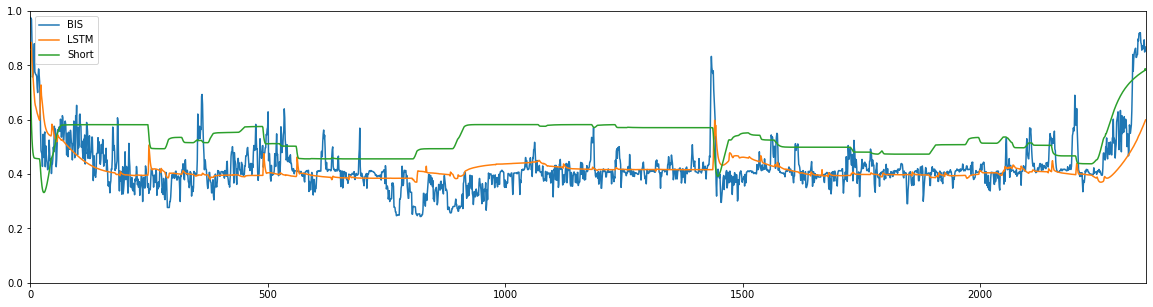

CaseID 6089, LSTM MAPE=28.59206199645996, Short MAPE=30.62408447265625


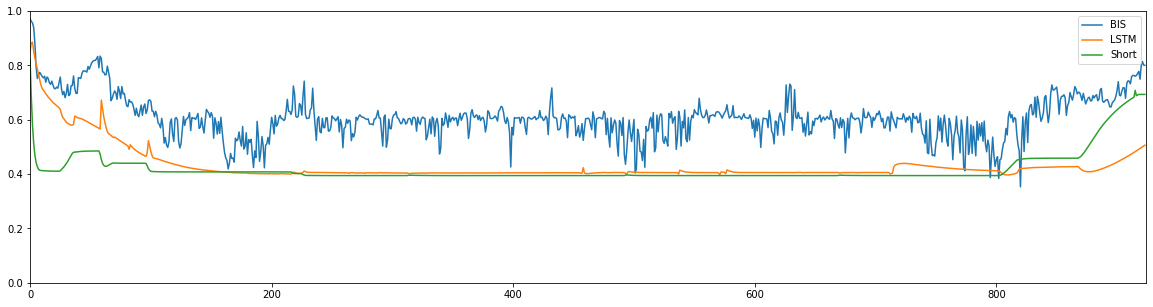

CaseID 6105, LSTM MAPE=22.75082015991211, Short MAPE=34.69951248168945


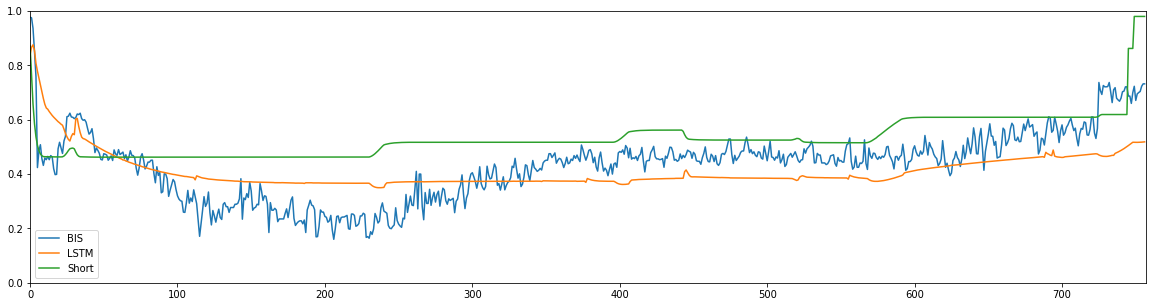

CaseID 6155, LSTM MAPE=18.192365646362305, Short MAPE=23.02593994140625


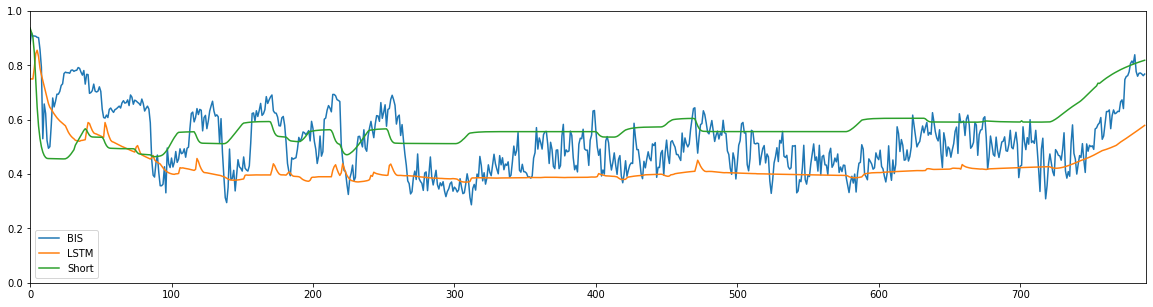

CaseID 6203, LSTM MAPE=16.443668365478516, Short MAPE=31.90904998779297


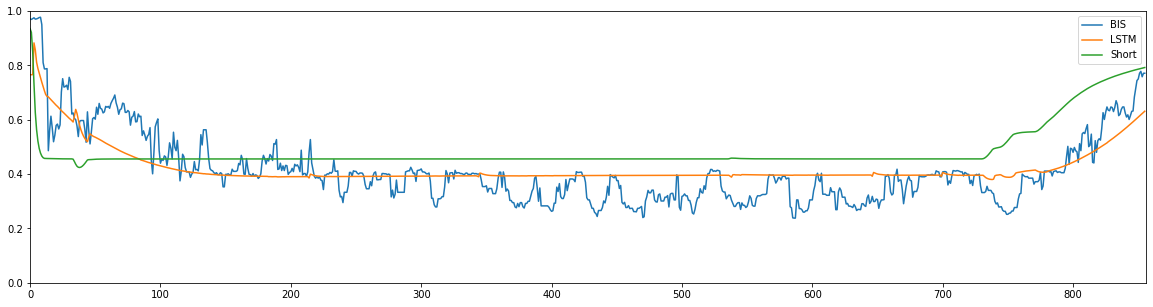

In [9]:
# Prediction
y_pred = model.predict(x_test).flatten()
print("Test MAPE: {}".format(mape(y_test, y_pred)))

# Plotting
import matplotlib.pyplot as plt
for caseid in test_caseids:
    case_mask = (c[test_mask] == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    print('CaseID {}, LSTM MAPE={}, Short MAPE={}'.format(caseid, 
      mape(y_test[case_mask], y_pred[case_mask]), 
      mape(y_test[case_mask], y_old[case_mask])
      ))

    t = np.arange(0, case_len)
    plt.figure(figsize=(20, 5))
    plt.plot(t, y_test[case_mask], label='BIS')  # Ground truth
    plt.plot(t, y_pred[case_mask], label='LSTM')  # LSTM model
    plt.plot(t, y_old[case_mask], label='Short')  # Short model
    plt.legend()
    plt.xlim([0, case_len])
    plt.ylim([0, 1])
    plt.show()